# Belgian production network model

## Prototyping

*Original code by Cyril Garneau. Modified by T.W. Alleman in consultation with the BIOMATH research unit headed by prof. Ingmar Nopens.*

Copyright (c) 2020 by T.W. Alleman, BIOMATH, Ghent University. All Rights Reserved.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# OPTIONAL: Load the "autoreload" extension so that package code can change
%load_ext autoreload
# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

In [26]:
from covid19model.data.economic_parameters import get_economic_parameters, get_conversion_matrix
from covid19model.models.economic_utils import *
from covid19model.models.time_dependant_parameter_fncs import *

### Load economic parameters

In [4]:
pars = get_economic_parameters()

### Testing of demand functions

TypeError: household_demand_shock() missing 2 required positional arguments: 'c_s' and 'on_site'

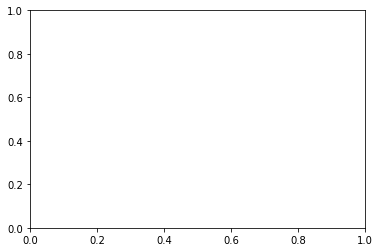

In [9]:
rho = 1-(1-0.6)/90 # recovery time constant
L = 0.2 # fraction of population expecting L-shaped recovery

t_start_lockdown = 30
t_end_lockdown = 30+60
t_end_pandemic = 30+60+365
simtime = 365*3

zeta_previous = 1

fig,ax = plt.subplots()

color=['red','black','blue']
i=0
for L in [0,0.5,1]:
    zeta=[]
    epsilon = np.empty(shape=[63,simtime])
    for time in np.arange(simtime):
        zeta.append(compute_income_expectations(time,{},zeta_previous,t_start_lockdown,t_end_lockdown,pars['l_0'],sum((1-pars['l_s'])*pars['l_0']),rho,L))
        zeta_previous = zeta[-1]
        epsilon[:,time] = list(household_demand_shock(time,t_start_lockdown,t_end_lockdown,t_end_pandemic,pars['c_s'],pars['on_site']))

    ax.plot(np.arange(simtime),zeta,color=color[i])
    i=i+1
    
ax.axvline(t_end_lockdown,color='black',ls='-.')
ax.set_title('Expected fraction of pre-pandemic labor income \n households expect to retain in the long run')
ax.set_xlabel('time (days)')
ax.set_ylabel('fraction of pre-pandemic income (-)')
lgd=ax.legend(['0 %','50 %', '100 %'],bbox_to_anchor=(1.05, 1), loc='upper left',title='Belief in L-shaped recovery:')
ax.grid('on')
fig.savefig('l_p.jpg',dpi=400,bbox_extra_artists=(lgd,), bbox_inches='tight')

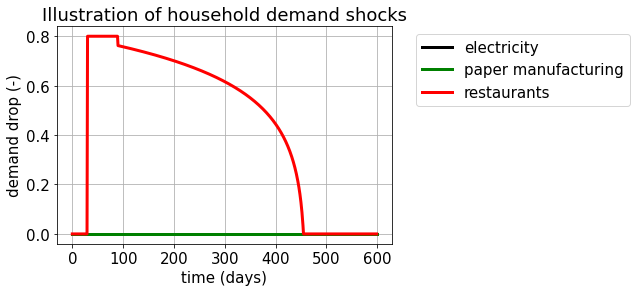

In [295]:
fig,ax = plt.subplots()
plottime = 600
ax.plot(np.arange(plottime),epsilon[23,:plottime],color='black')
ax.plot(np.arange(plottime),epsilon[7,:plottime],color='green')
ax.plot(np.arange(plottime),epsilon[-28,:plottime],color='red')
ax.plot()
ax.plot()
ax.set_title('Illustration of household demand shocks')
ax.set_xlabel('time (days)')
ax.set_ylabel('demand drop (-)')
lgd=ax.legend(['electricity','paper manufacturing','restaurants'],bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid('on')
fig.savefig('demand_shocks.jpg',dpi=400,bbox_extra_artists=(lgd,), bbox_inches='tight')

### Testing of full model

In [304]:
# Parameters
# ----------
rho = 1-(1-0.6)/90 # recovery time constant
L = 0 # fraction of population expecting L-shaped recovery
delta_S = 0.5
m = sum(pars['c_0'])/sum(pars['l_0'])
tau = 10
b = 0
gamma_F = 1/7
gamma_H = 1/30

# Timing
# ------
t_start_lockdown = 30
t_end_lockdown = 30+60
t_end_pandemic = 30+60+365
simtime = 500

# Initialisation
# --------------
theta_0 = pars['c_0']/sum(pars['c_0'])
zeta_previous = 1
c_total_previous = sum(pars['c_0']) # Total household demand under business-as-usual
d_t_previous = pars['x_0'] # Demand = Output at start simulation
S_t = pars['S_0']

c_t_array = np.expand_dims(pars['c_0'],axis=1)
O_t_array = np.expand_dims(pars['O_j'],axis=1)
S_t_array = np.expand_dims(np.sum(pars['S_0'],axis=1),axis=1)
d_t_array = np.expand_dims(pars['x_0'],axis=1)
x_t_array = np.expand_dims(pars['x_0'],axis=1)
f_t_array = np.expand_dims(pars['f_0'],axis=1)
l_t = pars['l_0']
l_t_array = np.expand_dims(pars['l_0'],axis=1)

# Simulation loop
# ---------------
for time in np.arange(1,simtime):
    
    # Demand and supply shocks
    # ------------------------
    # Labor
    epsilon_S = labor_supply_shock(time,t_start_lockdown,t_end_lockdown,pars['l_s'])
    # Household demand
    epsilon_D = household_demand_shock(time,t_start_lockdown,t_end_lockdown,t_end_pandemic,pars['c_s'],pars['on_site'])
    # Other demand
    if time < t_start_lockdown:
        f_t = pars['f_0']
    elif ((time >= t_start_lockdown) & (time < t_end_lockdown)):
        f_t = pars['f_0']*(1-pars['f_s'])
    else:
        f_t = pars['f_0']

    # Government intervention
    # -----------------------
    l_t_star = labor_compensation_intervention(time, t_start_lockdown, t_end_pandemic, l_t, pars['l_0'], b)

    # Productive capacity
    # -------------------
    x_t_cap = calc_labor_restriction(pars['x_0'],pars['l_0'],l_t)

    # Input bottlenecks
    # -----------------
    x_t_inp = calc_input_restriction(S_t,pars['A'],pars['C'])

    # Total consumer demand
    # ---------------------

    # Compute preference vector
    theta = household_preference_shock(epsilon_D, theta_0)
    # Compute aggregate demand shock
    epsilon_t = aggregate_demand_shock(epsilon_D, theta_0, delta_S, rho)
    # Compute expected long term labor income (Eq. 22, 23)
    zeta = household_income_expectations(time,zeta_previous,t_start_lockdown,t_end_lockdown,pars['l_0'],sum((1-pars['l_s'])*pars['l_0']),rho,L)
    l_p = zeta*sum(pars['l_0'])
    # Compute total consumer demand (per sector)
    c_t = theta*calc_household_demand(c_total_previous,l_t_star,l_p,epsilon_t,rho,m)
    c_t_array = np.append(c_t_array, np.expand_dims(c_t,axis=1), axis = 1)

    # Intermediate demand
    # -------------------
    O = calc_intermediate_demand(d_t_previous,S_t,pars['A'],pars['S_0'],tau)
    O_t_array = np.append(O_t_array,np.expand_dims(np.sum(O,axis=1),axis=1),axis=1)

    # Total demand
    # ------------
    d_t = calc_total_demand(O,c_t,f_t)
    d_t_array = np.append(d_t_array, np.expand_dims(d_t,axis=1), axis=1)

    # Leontief production function
    # ----------------------------
    x_t = leontief(x_t_cap, x_t_inp, d_t)
    x_t_array = np.append(x_t_array, np.expand_dims(x_t,axis=1), axis=1)
    
    # Rationing
    # ---------
    O,c_t,f_t = rationing(x_t,d_t,O,c_t,f_t)
    f_t_array = np.append(f_t_array, np.expand_dims(f_t,axis=1), axis = 1)
    
    # Update inventories
    # ------------------
    S_t = inventory_updating(S_t,O,x_t,pars['A'])
    S_t_array = np.append(S_t_array, np.expand_dims(np.sum(S_t,axis=1),axis=1), axis=1)
    
    # Hire/fire workers
    # -----------------
    l_t = hiring_firing(l_t, pars['l_0'], pars['x_0'], x_t_inp, x_t_cap, d_t, gamma_F, gamma_H, epsilon_S)
    l_t_array = np.append(l_t_array, np.expand_dims(l_t,axis=1), axis=1)
    
    # Update other states
    # -------------------
    c_total_previous = sum(theta*calc_household_demand(c_total_previous,l_t_star,l_p,epsilon_t,rho,m))
    d_t_previous = d_t
    zeta_previous = zeta

[autoreload of covid19model.models.models failed: Traceback (most recent call last):
  File "/home/twallema/anaconda3/envs/COVID_MODEL/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/home/twallema/anaconda3/envs/COVID_MODEL/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 410, in superreload
    update_generic(old_obj, new_obj)
  File "/home/twallema/anaconda3/envs/COVID_MODEL/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 347, in update_generic
    update(a, b)
  File "/home/twallema/anaconda3/envs/COVID_MODEL/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 292, in update_class
    if (old_obj == new_obj) is True:
ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()
]


TypeError: labor_supply_shock() missing 1 required positional argument: 'l_s'

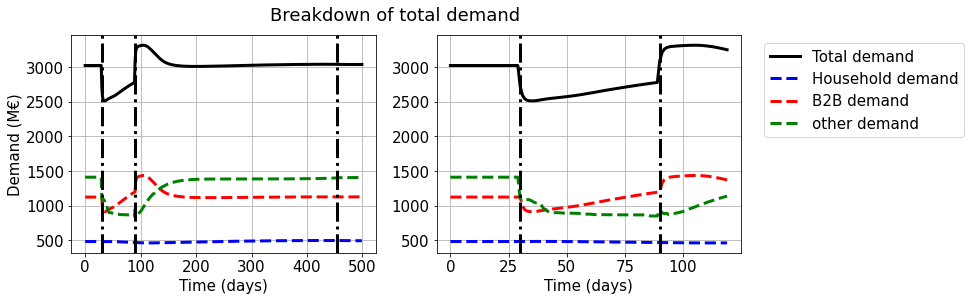

In [297]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(12,4))
fig.suptitle('Breakdown of total demand')

ax1.plot(np.arange(0,simtime),np.sum(d_t_array,axis=0),color='black')
ax1.plot(np.arange(0,simtime),np.sum(c_t_array,axis=0),color='blue',ls='--')
ax1.plot(np.arange(0,simtime),np.sum(O_t_array,axis=0),color='red',ls='--')
ax1.plot(np.arange(0,simtime),np.sum(f_t_array,axis=0),color='green',ls='--')
ax1.axvline(t_start_lockdown,color='black',linestyle='-.')
ax1.axvline(t_end_lockdown,color='black',linestyle='-.')
ax1.axvline(t_end_pandemic,color='black',linestyle='-.')
ax1.set_xlabel('Time (days)')
ax1.set_ylabel('Demand (M€)')
ax1.grid('on')

ax2.plot(np.arange(0,t_end_lockdown+30),np.sum(d_t_array,axis=0)[0:t_end_lockdown+30],color='black')
ax2.plot(np.arange(0,t_end_lockdown+30),np.sum(c_t_array,axis=0)[0:t_end_lockdown+30],color='blue',ls='--')
ax2.plot(np.arange(0,t_end_lockdown+30),np.sum(O_t_array,axis=0)[0:t_end_lockdown+30],color='red',ls='--')
ax2.plot(np.arange(0,t_end_lockdown+30),np.sum(f_t_array,axis=0)[0:t_end_lockdown+30],color='green',ls='--')
ax2.axvline(t_start_lockdown,color='black',linestyle='-.')
ax2.axvline(t_end_lockdown,color='black',linestyle='-.')
ax2.set_xlabel('Time (days)')
lgd=ax2.legend(['Total demand','Household demand','B2B demand','other demand'],bbox_to_anchor=(1.05, 1), loc='upper left')
ax2.grid('on')
fig.savefig('demand_breakdown.jpg',dpi=400,bbox_extra_artists=(lgd,), bbox_inches='tight')

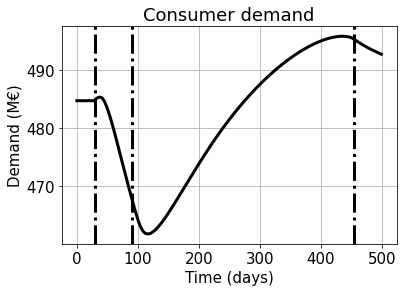

In [277]:
fig,ax=plt.subplots()
ax.plot(np.arange(0,simtime),np.sum(c_t_array,axis=0),color='black')
ax.axvline(t_start_lockdown,color='black',linestyle='-.')
ax.axvline(t_end_lockdown,color='black',linestyle='-.')
ax.axvline(t_end_pandemic,color='black',linestyle='-.')
ax.set_title('Consumer demand')
ax.set_xlabel('Time (days)')
ax.set_ylabel('Demand (M€)')
ax.grid('on')
fig.savefig('consumer_government.jpg',dpi=400)

Text(0, 0.5, 'Output (M€)')

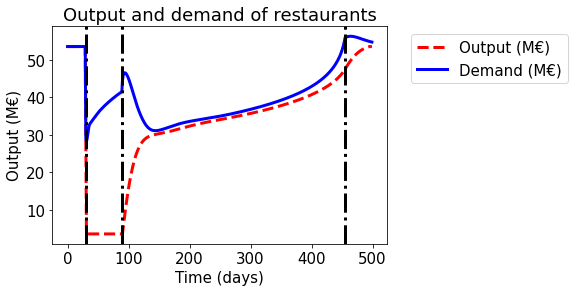

In [278]:
fig,ax=plt.subplots()
ax.plot(np.arange(0,simtime),x_t_array[-28,:],color='red',ls='--')
ax.plot(np.arange(0,simtime),d_t_array[-28,:],color='blue')
ax.axvline(t_start_lockdown,color='black',linestyle='-.')
ax.axvline(t_end_lockdown,color='black',linestyle='-.')
ax.axvline(t_end_pandemic,color='black',linestyle='-.')
ax.set_title('Output and demand of restaurants')
ax.legend(['Output (M€)','Demand (M€)'],bbox_to_anchor=(1.05, 1), loc='upper left')
ax.set_xlabel('Time (days)')
ax.set_ylabel('Output (M€)')

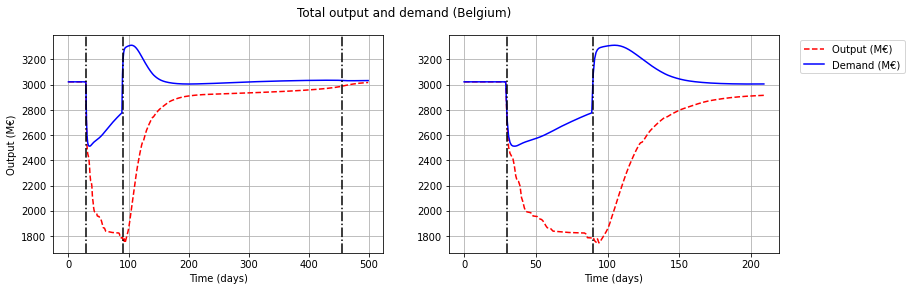

In [14]:
fig,(ax1,ax2)=plt.subplots(1, 2,figsize=(13,4))

fig.suptitle('Total output and demand (Belgium)')
ax1.plot(np.arange(0,simtime),np.sum(x_t_array,axis=0),color='red',ls='--')
ax1.plot(np.arange(0,simtime),np.sum(d_t_array,axis=0),color='blue')
ax1.axvline(t_start_lockdown,color='black',linestyle='-.')
ax1.axvline(t_end_lockdown,color='black',linestyle='-.')
ax1.axvline(t_end_pandemic,color='black',linestyle='-.')
ax1.set_xlabel('Time (days)')
ax1.set_ylabel('Output (M€)')
ax1.grid('on')

ax2.plot(np.arange(0,t_end_lockdown+120),np.sum(x_t_array,axis=0)[0:t_end_lockdown+120],color='red',ls='--')
ax2.plot(np.arange(0,t_end_lockdown+120),np.sum(d_t_array,axis=0)[0:t_end_lockdown+120],color='blue')
ax2.axvline(t_start_lockdown,color='black',linestyle='-.')
ax2.axvline(t_end_lockdown,color='black',linestyle='-.')
lgd=ax2.legend(['Output (M€)','Demand (M€)'],bbox_to_anchor=(1.05, 1), loc='upper left')
ax2.set_xlabel('Time (days)')
ax2.grid('on')

fig.savefig('total_output_demand.jpg',dpi=400,bbox_extra_artists=(lgd,), bbox_inches='tight')

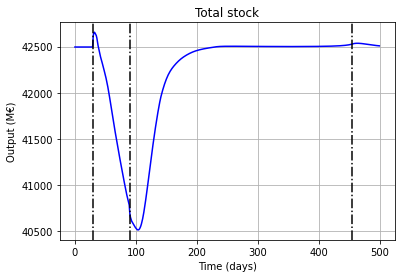

In [15]:
fig,ax=plt.subplots()
ax.plot(np.arange(0,simtime),np.sum(S_t_array,axis=0),color='blue')
ax.axvline(t_start_lockdown,color='black',linestyle='-.')
ax.axvline(t_end_lockdown,color='black',linestyle='-.')
ax.axvline(t_end_pandemic,color='black',linestyle='-.')
ax.set_title('Total stock')
ax.set_xlabel('Time (days)')
ax.set_ylabel('Output (M€)')
ax.grid('on')
plt.savefig('total_stock.jpg',dpi=400)

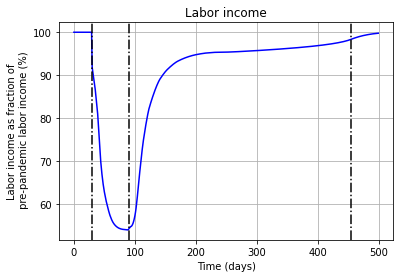

In [16]:
fig,ax=plt.subplots()
ax.plot(np.arange(0,simtime),(np.sum(l_t_array,axis=0)/np.sum(pars['l_0'],axis=0)*100),color='blue')
ax.axvline(t_start_lockdown,color='black',linestyle='-.')
ax.axvline(t_end_lockdown,color='black',linestyle='-.')
ax.axvline(t_end_pandemic,color='black',linestyle='-.')
ax.set_title('Labor income')
ax.set_xlabel('Time (days)')
ax.set_ylabel('Labor income as fraction of\n pre-pandemic labor income (%)')
ax.grid('on')
fig.savefig('active_workers.jpg',dpi=400)

In [17]:
x_t_10 = np.matmul(get_conversion_matrix('NACE21_NACE10'),np.matmul(get_conversion_matrix('NACE38_NACE21'),np.matmul(get_conversion_matrix('NACE64_NACE38'),np.expand_dims(x_t_array[:,0],axis=1))))
d_t_10 = np.matmul(get_conversion_matrix('NACE21_NACE10'),np.matmul(get_conversion_matrix('NACE38_NACE21'),np.matmul(get_conversion_matrix('NACE64_NACE38'),np.expand_dims(d_t_array[:,0],axis=1))))
l_t_10 = np.matmul(get_conversion_matrix('NACE21_NACE10'),np.matmul(get_conversion_matrix('NACE38_NACE21'),np.matmul(get_conversion_matrix('NACE64_NACE38'),np.expand_dims(l_t_array[:,0],axis=1))))

for i in range(1,x_t_array[0,:].shape[0]):
    print(i)
    x_t_10 = np.append(x_t_10,np.matmul(get_conversion_matrix('NACE21_NACE10'),np.matmul(get_conversion_matrix('NACE38_NACE21'),np.matmul(get_conversion_matrix('NACE64_NACE38'),np.expand_dims(x_t_array[:,i],axis=1)))),axis=1)
    d_t_10 = np.append(d_t_10,np.matmul(get_conversion_matrix('NACE21_NACE10'),np.matmul(get_conversion_matrix('NACE38_NACE21'),np.matmul(get_conversion_matrix('NACE64_NACE38'),np.expand_dims(d_t_array[:,i],axis=1)))),axis=1)
    l_t_10 = np.append(l_t_10,np.matmul(get_conversion_matrix('NACE21_NACE10'),np.matmul(get_conversion_matrix('NACE38_NACE21'),np.matmul(get_conversion_matrix('NACE64_NACE38'),np.expand_dims(l_t_array[:,i],axis=1)))),axis=1)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [18]:
labels=pd.read_excel("../../data/interim/economical/conversion_matrices.xlsx", sheet_name = 'NACE 21 to NACE 10', header=[0], index_col=[0]).index.values

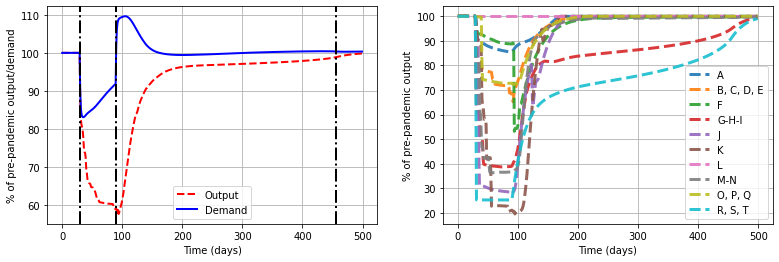

In [19]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(13,4))

ax1.plot(np.arange(0,simtime),np.sum(x_t_array,axis=0)/np.sum(x_t_array,axis=0)[0]*100,color='red',ls='--',linewidth=2)
ax1.plot(np.arange(0,simtime),np.sum(d_t_array,axis=0)/np.sum(d_t_array,axis=0)[0]*100,color='blue',linewidth=2)
ax1.axvline(t_start_lockdown,color='black',linestyle='-.',linewidth=2)
ax1.axvline(t_end_lockdown,color='black',linestyle='-.',linewidth=2)
ax1.axvline(t_end_pandemic,color='black',linestyle='-.',linewidth=2)
ax1.legend(['Output','Demand'])
ax1.set_xlabel('Time (days)')
ax1.set_ylabel('% of pre-pandemic output/demand')
ax1.grid('on')

for i in range(x_t_10.shape[0]):
    ax2.plot(np.arange(0,simtime),(x_t_10[i,:]/x_t_10[i,0]*100),ls='--',linewidth=3, alpha=0.9)
    
ax2.grid('on')
ax2.set_xlabel('Time (days)')
ax2.set_ylabel('% of pre-pandemic output')
ax2.legend(labels)
fig.savefig('output_breakdown_NACE10.jpg',dpi=400, bbox_inches='tight')

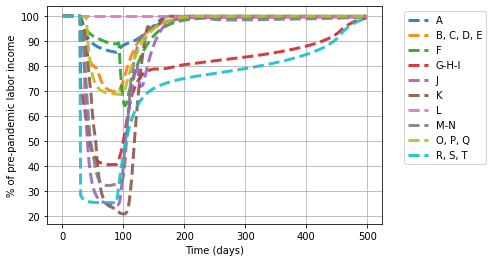

In [20]:
fig,ax=plt.subplots()

for i in range(x_t_10.shape[0]):
    ax.plot(np.arange(0,simtime),l_t_10[i,:]/l_t_10[i,0]*100,ls='--',linewidth=3, alpha=0.9)
    
ax.grid('on')
ax.set_xlabel('Time (days)')
ax.set_ylabel('% of pre-pandemic labor income')
ax.legend(labels,bbox_to_anchor=(1.05, 1), loc='upper left')
fig.savefig('labor_breakdown_NACE10.jpg',dpi=400, bbox_inches='tight')

In [21]:
import datetime
df = pd.read_excel("../../data/interim/economical/ERMG_revenue_survey.xlsx",index_col=[0], header=[0])
datetime_dates=[datetime.datetime.strptime(date,"%Y-%m-%d") for date in df.columns]

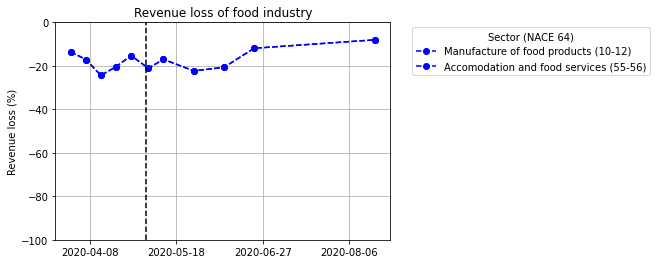

In [22]:
# Manufacture of food products

fig,ax = plt.subplots()

ax.plot(datetime_dates,df.loc['10-12'],color='blue',ls='--',marker='o')
ax.plot(datetime_dates,df.loc['10-12'],color='blue',ls='--',marker='o')

ax.set_ylim([-100,0])
ax.xaxis.set_major_locator(plt.MaxNLocator(4))
ax.yaxis.set_major_locator(plt.MaxNLocator(5))
ax.axvline(datetime.datetime.strptime('2020-05-04',"%Y-%m-%d"),color='black',ls='--')
ax.set_ylabel('Revenue loss (%)')
ax.set_title('Revenue loss of food industry')
lgd=ax.legend(['Manufacture of food products (10-12)', 'Accomodation and food services (55-56)'], title='Sector (NACE 64)', bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid('on')
fig.savefig('food_sector.jpg',dpi=400,bbox_extra_artists=(lgd,), bbox_inches='tight')

### Attempt to incorporate in modeling framework of BIOMATH

In [11]:
from covid19model.models import models
from covid19model.data.economic_parameters import get_economic_parameters
from covid19model.models.economic_utils import *
from covid19model.models.time_dependant_parameter_fncs import *

In [12]:
# Load the parameters using `get_economic_parameters()`.
params = get_economic_parameters()

# Parameters
# ----------
start_date = '2020-03-01'
end_date = '2020-12-31'
t_start_lockdown = pd.Timestamp('2020-03-15')
t_end_lockdown =pd.Timestamp('2020-05-04')
t_end_pandemic = pd.Timestamp('2020-08-01')
                    
params.update({'rho': 1-(1-0.6)/90, # Economic recovery time (0.6 quarters?)
               'delta_S': 0.5, # household savings rate (delta_S = 1; households save all money they are not spending due to shock)
               'L': 0.5, # Fraction of population believing in L-shaped recovery
               'l_start_lockdown': sum((1-params['l_s'])*params['l_0']), # Verify this must be the sum
               'zeta': 1,
               'tau': 10, # Restock rate (days)
               'gamma_F': 1/7, # Firing rate (days-1)
               'gamma_H': 1/28 }) # Hiring rate (days-1)


# Time-dependent parameters
# -------------------------
params.update({'epsilon_S': np.zeros([params['c_s'].shape[0]]),
                'epsilon_D': np.zeros([params['c_s'].shape[0]]),
                'epsilon_F': np.zeros([params['c_s'].shape[0]]),
                't_start_lockdown': t_start_lockdown,
                't_end_lockdown': t_end_lockdown,
                't_end_pandemic': t_end_pandemic,
                'b': 0,
                'b_s': 0,
                't_start_compensation': pd.Timestamp('2020-04-01'),
                't_end_compensation': pd.Timestamp('2020-07-01')})

# Load initial states
initial_states = {'x': params['x_0'],
                  'c': params['c_0'],
                  'c_desired': params['c_0'],
                  'f': params['f_0'],
                  'd': params['x_0'],
                  'l': params['l_0'],
                  'O': params['O_j'],
                  'S': params['S_0']}

# Initialize the model
model = models.Economic_Model(initial_states, params, discrete=True, time_dependent_parameters={'epsilon_S': labor_supply_shock,
                                                                                                'epsilon_D': household_demand_shock,
                                                                                                'epsilon_F': other_demand_shock,
                                                                                                'b': government_furloughing,
                                                                                                'zeta': compute_income_expectations})

In [13]:
out=model.sim(end_date, start_date=start_date, warmup=0)

/home/twallema/Documents/PhD/Corona/Python/git/COVID19-Model/src/covid19model/models/economic_utils.py:48: RuntimeWarning: invalid value encountered in true_divide
  x_t[i] = np.nanmin(S_t[np.where(C[i,:] == 1),i]/A[np.where(C[i,:] == 1),i])
/home/twallema/Documents/PhD/Corona/Python/git/COVID19-Model/src/covid19model/models/economic_utils.py:48: RuntimeWarning: All-NaN slice encountered
  x_t[i] = np.nanmin(S_t[np.where(C[i,:] == 1),i]/A[np.where(C[i,:] == 1),i])


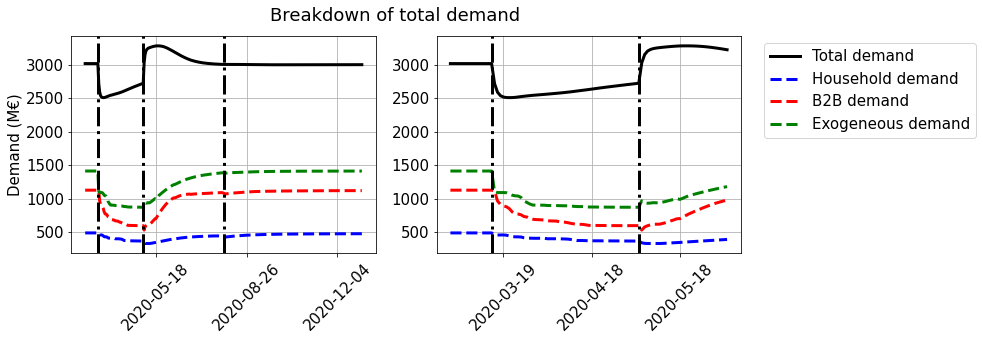

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(12,4))
fig.suptitle('Breakdown of total demand')

ax1.plot(out['time'],out['d'].sum(dim='A'),color='black')
ax1.plot(out['time'],out['c'].sum(dim='A'),color='blue',ls='--')
ax1.plot(out['time'],out['O'].sum(dim='A'),color='red',ls='--')
ax1.plot(out['time'],out['f'].sum(dim='A'),color='green',ls='--')
ax1.axvline(t_start_lockdown,color='black',linestyle='-.')
ax1.axvline(t_end_lockdown,color='black',linestyle='-.')
ax1.axvline(t_end_pandemic,color='black',linestyle='-.')
ax1.set_ylabel('Demand (M€)')
ax1.grid('on')
ax1.xaxis.set_major_locator(plt.MaxNLocator(4))
for tick in ax1.get_xticklabels():
    tick.set_rotation(45)
    
ax2.plot(out['time'].sel(time=slice(start_date, t_end_lockdown+pd.Timedelta(days=30))),out['d'].sum(dim='A').sel(time=slice(start_date, t_end_lockdown+pd.Timedelta(days=30))),color='black')
ax2.plot(out['time'].sel(time=slice(start_date, t_end_lockdown+pd.Timedelta(days=30))),out['c'].sum(dim='A').sel(time=slice(start_date, t_end_lockdown+pd.Timedelta(days=30))),color='blue',ls='--')
ax2.plot(out['time'].sel(time=slice(start_date, t_end_lockdown+pd.Timedelta(days=30))),out['O'].sum(dim='A').sel(time=slice(start_date, t_end_lockdown+pd.Timedelta(days=30))),color='red',ls='--')
ax2.plot(out['time'].sel(time=slice(start_date, t_end_lockdown+pd.Timedelta(days=30))),out['f'].sum(dim='A').sel(time=slice(start_date, t_end_lockdown+pd.Timedelta(days=30))),color='green',ls='--')
ax2.axvline(t_start_lockdown,color='black',linestyle='-.')
ax2.axvline(t_end_lockdown,color='black',linestyle='-.')
ax2.xaxis.set_major_locator(plt.MaxNLocator(4))
for tick in ax2.get_xticklabels():
    tick.set_rotation(45)
lgd=ax2.legend(['Total demand','Household demand','B2B demand','Exogeneous demand'],bbox_to_anchor=(1.05, 1), loc='upper left')
ax2.grid('on')

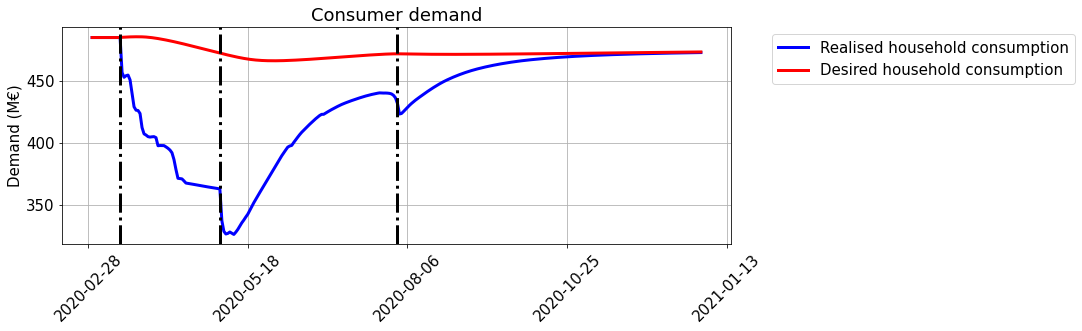

In [23]:
fig,ax=plt.subplots(figsize=(12,4))
ax.plot(out['time'],out['c'].sum(dim='A'),color='blue')
ax.plot(out['time'],out['c_desired'].sum(dim='A'),color='red')
ax.axvline(t_start_lockdown,color='black',linestyle='-.')
ax.axvline(t_end_lockdown,color='black',linestyle='-.')
ax.axvline(t_end_pandemic,color='black',linestyle='-.')
ax.set_title('Consumer demand')
ax.xaxis.set_major_locator(plt.MaxNLocator(5))
for tick in ax.get_xticklabels():
    tick.set_rotation(45)
ax.set_ylabel('Demand (M€)')
lgd=ax.legend(['Realised household consumption','Desired household consumption'],bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid('on')

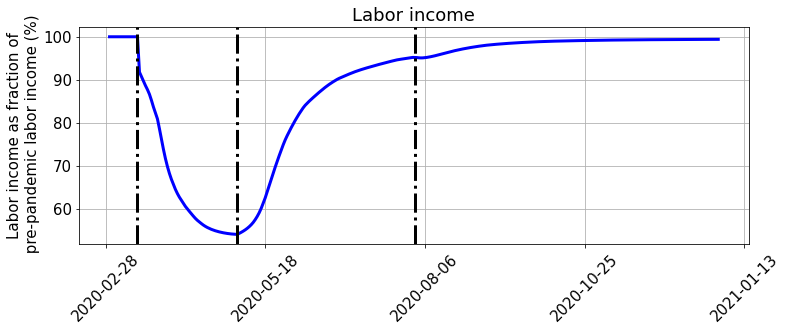

In [22]:
fig,ax=plt.subplots(figsize=(12,4))
ax.plot(out['time'],(out['l'].sum(dim='A')/np.sum(params['l_0'],axis=0)*100),color='blue')
ax.axvline(t_start_lockdown,color='black',linestyle='-.')
ax.axvline(t_end_lockdown,color='black',linestyle='-.')
ax.axvline(t_end_pandemic,color='black',linestyle='-.')
ax.set_title('Labor income')
ax.xaxis.set_major_locator(plt.MaxNLocator(5))
for tick in ax.get_xticklabels():
    tick.set_rotation(45)
ax.set_ylabel('Labor income as fraction of\n pre-pandemic labor income (%)')
ax.grid('on')

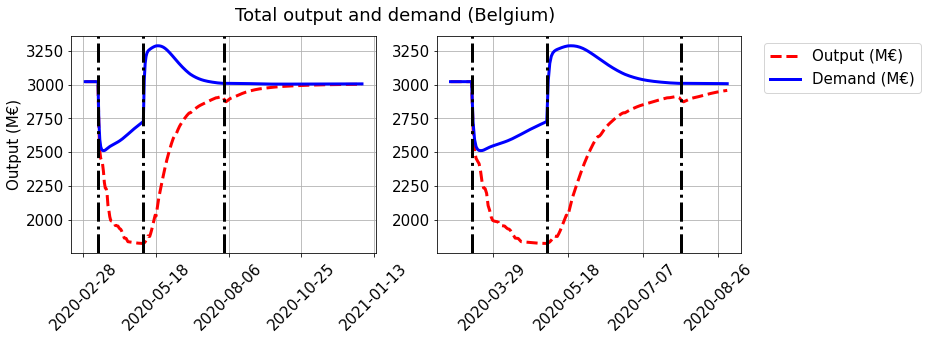

In [21]:
fig,(ax1,ax2)=plt.subplots(1, 2,figsize=(12,4))

fig.suptitle('Total output and demand (Belgium)')
ax1.plot(out['time'],out['x'].sum(dim='A'),color='red',ls='--')
ax1.plot(out['time'],out['d'].sum(dim='A'),color='blue')
ax1.axvline(t_start_lockdown,color='black',linestyle='-.')
ax1.axvline(t_end_lockdown,color='black',linestyle='-.')
ax1.axvline(t_end_pandemic,color='black',linestyle='-.')
ax1.xaxis.set_major_locator(plt.MaxNLocator(5))
for tick in ax1.get_xticklabels():
    tick.set_rotation(45)
ax1.set_ylabel('Output (M€)')
ax1.grid('on')

ax2.plot(out['time'].sel(time=slice(start_date, t_end_lockdown+pd.Timedelta(days=120))),out['x'].sum(dim='A').sel(time=slice(start_date, t_end_lockdown+pd.Timedelta(days=120))),color='red',ls='--')
ax2.plot(out['time'].sel(time=slice(start_date, t_end_lockdown+pd.Timedelta(days=120))),out['d'].sum(dim='A').sel(time=slice(start_date, t_end_lockdown+pd.Timedelta(days=120))),color='blue')
ax2.axvline(t_start_lockdown,color='black',linestyle='-.')
ax2.axvline(t_end_lockdown,color='black',linestyle='-.')
ax2.axvline(t_end_pandemic,color='black',linestyle='-.')
ax2.xaxis.set_major_locator(plt.MaxNLocator(5))
for tick in ax2.get_xticklabels():
    tick.set_rotation(45)
lgd=ax2.legend(['Output (M€)','Demand (M€)'],bbox_to_anchor=(1.05, 1), loc='upper left')

ax2.grid('on')

In [115]:
def NACE64toNACE10(state_name,out):
    for idx,time in enumerate(out['time'].values):
        if idx == 0:
            aggregated_state = np.matmul(get_conversion_matrix('NACE21_NACE10'),np.matmul(get_conversion_matrix('NACE38_NACE21'),np.matmul(get_conversion_matrix('NACE64_NACE38'),np.expand_dims(out[state_name].sel(time=time).values,axis=1))))
        else:
            aggregated_state = np.append(aggregated_state, np.matmul(get_conversion_matrix('NACE21_NACE10'),np.matmul(get_conversion_matrix('NACE38_NACE21'),np.matmul(get_conversion_matrix('NACE64_NACE38'),np.expand_dims(out[state_name].sel(time=time).values,axis=1)))), axis=1)
    return aggregated_state

In [111]:
x_10 = NACE64toNACE10('x',out)

[[  48.92919869]
 [1231.42111601]
 [ 187.19863868]
 [ 512.72126909]
 [ 127.46846122]
 [ 138.93093873]
 [ 127.06231781]
 [ 298.03677428]
 [ 298.21742844]
 [  52.42301674]]
[[  48.92919869]
 [1231.42111601]
 [ 187.19863868]
 [ 512.72126909]
 [ 127.46846122]
 [ 138.93093873]
 [ 127.06231781]
 [ 298.03677428]
 [ 298.21742844]
 [  52.42301674]]
[[  48.92919869   48.92919869]
 [1231.42111601 1231.42111601]
 [ 187.19863868  187.19863868]
 [ 512.72126909  512.72126909]
 [ 127.46846122  127.46846122]
 [ 138.93093873  138.93093873]
 [ 127.06231781  127.06231781]
 [ 298.03677428  298.03677428]
 [ 298.21742844  298.21742844]
 [  52.42301674   52.42301674]]
[[  48.92919869   48.92919869   48.92919869]
 [1231.42111601 1231.42111601 1231.42111601]
 [ 187.19863868  187.19863868  187.19863868]
 [ 512.72126909  512.72126909  512.72126909]
 [ 127.46846122  127.46846122  127.46846122]
 [ 138.93093873  138.93093873  138.93093873]
 [ 127.06231781  127.06231781  127.06231781]
 [ 298.03677428  298.03677428  2

[[  48.92919869   48.92919869   48.92919869   48.92919869   48.92919869
    48.92919869   48.92919869   48.92919869   48.92919869   48.92919869
    48.92919869]
 [1231.42111601 1231.42111601 1231.42111601 1231.42111601 1231.42111601
  1231.42111601 1231.42111601 1231.42111601 1231.42111601 1231.42111601
  1231.42111601]
 [ 187.19863868  187.19863868  187.19863868  187.19863868  187.19863868
   187.19863868  187.19863868  187.19863868  187.19863868  187.19863868
   187.19863868]
 [ 512.72126909  512.72126909  512.72126909  512.72126909  512.72126909
   512.72126909  512.72126909  512.72126909  512.72126909  512.72126909
   512.72126909]
 [ 127.46846122  127.46846122  127.46846122  127.46846122  127.46846122
   127.46846122  127.46846122  127.46846122  127.46846122  127.46846122
   127.46846122]
 [ 138.93093873  138.93093873  138.93093873  138.93093873  138.93093873
   138.93093873  138.93093873  138.93093873  138.93093873  138.93093873
   138.93093873]
 [ 127.06231781  127.06231781  127

[[  48.92919869   48.92919869   48.92919869   48.92919869   48.92919869
    48.92919869   48.92919869   48.92919869   48.92919869   48.92919869
    48.92919869   48.92919869   48.92919869   48.92919869   48.92919869
    48.89726567   46.62976617]
 [1231.42111601 1231.42111601 1231.42111601 1231.42111601 1231.42111601
  1231.42111601 1231.42111601 1231.42111601 1231.42111601 1231.42111601
  1231.42111601 1231.42111601 1231.42111601 1231.42111601 1231.42111601
  1068.12269021 1009.2808711 ]
 [ 187.19863868  187.19863868  187.19863868  187.19863868  187.19863868
   187.19863868  187.19863868  187.19863868  187.19863868  187.19863868
   187.19863868  187.19863868  187.19863868  187.19863868  187.19863868
   181.43034119  178.11342827]
 [ 512.72126909  512.72126909  512.72126909  512.72126909  512.72126909
   512.72126909  512.72126909  512.72126909  512.72126909  512.72126909
   512.72126909  512.72126909  512.72126909  512.72126909  512.72126909
   386.65199901  327.85471615]
 [ 127.46846

[[  48.92919869   48.92919869   48.92919869   48.92919869   48.92919869
    48.92919869   48.92919869   48.92919869   48.92919869   48.92919869
    48.92919869   48.92919869   48.92919869   48.92919869   48.92919869
    48.89726567   46.62976617   44.98477933   44.34650636   44.09607157
    43.99703705]
 [1231.42111601 1231.42111601 1231.42111601 1231.42111601 1231.42111601
  1231.42111601 1231.42111601 1231.42111601 1231.42111601 1231.42111601
  1231.42111601 1231.42111601 1231.42111601 1231.42111601 1231.42111601
  1068.12269021 1009.2808711   986.09132595  977.04770076  973.62155978
   972.44653776]
 [ 187.19863868  187.19863868  187.19863868  187.19863868  187.19863868
   187.19863868  187.19863868  187.19863868  187.19863868  187.19863868
   187.19863868  187.19863868  187.19863868  187.19863868  187.19863868
   181.43034119  178.11342827  175.85538693  174.62966916  174.01448384
   173.72441923]
 [ 512.72126909  512.72126909  512.72126909  512.72126909  512.72126909
   512.721269

[[  48.92919869   48.92919869   48.92919869   48.92919869   48.92919869
    48.92919869   48.92919869   48.92919869   48.92919869   48.92919869
    48.92919869   48.92919869   48.92919869   48.92919869   48.92919869
    48.89726567   46.62976617   44.98477933   44.34650636   44.09607157
    43.99703705   43.9573221    43.90364647   43.83671143   43.76482137]
 [1231.42111601 1231.42111601 1231.42111601 1231.42111601 1231.42111601
  1231.42111601 1231.42111601 1231.42111601 1231.42111601 1231.42111601
  1231.42111601 1231.42111601 1231.42111601 1231.42111601 1231.42111601
  1068.12269021 1009.2808711   986.09132595  977.04770076  973.62155978
   972.44653776  972.04573731  971.47735829  970.80298057  970.19314687]
 [ 187.19863868  187.19863868  187.19863868  187.19863868  187.19863868
   187.19863868  187.19863868  187.19863868  187.19863868  187.19863868
   187.19863868  187.19863868  187.19863868  187.19863868  187.19863868
   181.43034119  178.11342827  175.85538693  174.62966916  174

[[  48.92919869   48.92919869   48.92919869   48.92919869   48.92919869
    48.92919869   48.92919869   48.92919869   48.92919869   48.92919869
    48.92919869   48.92919869   48.92919869   48.92919869   48.92919869
    48.89726567   46.62976617   44.98477933   44.34650636   44.09607157
    43.99703705   43.9573221    43.90364647   43.83671143   43.76482137
    43.693784     43.62060638   43.5431704    43.46425853]
 [1231.42111601 1231.42111601 1231.42111601 1231.42111601 1231.42111601
  1231.42111601 1231.42111601 1231.42111601 1231.42111601 1231.42111601
  1231.42111601 1231.42111601 1231.42111601 1231.42111601 1231.42111601
  1068.12269021 1009.2808711   986.09132595  977.04770076  973.62155978
   972.44653776  972.04573731  971.47735829  970.80298057  970.19314687
   969.49835518  968.42647309  967.11313363  965.60388178]
 [ 187.19863868  187.19863868  187.19863868  187.19863868  187.19863868
   187.19863868  187.19863868  187.19863868  187.19863868  187.19863868
   187.19863868  1

[[  48.92919869   48.92919869   48.92919869   48.92919869   48.92919869
    48.92919869   48.92919869   48.92919869   48.92919869   48.92919869
    48.92919869   48.92919869   48.92919869   48.92919869   48.92919869
    48.89726567   46.62976617   44.98477933   44.34650636   44.09607157
    43.99703705   43.9573221    43.90364647   43.83671143   43.76482137
    43.693784     43.62060638   43.5431704    43.46425853   43.3828075
    43.30156046]
 [1231.42111601 1231.42111601 1231.42111601 1231.42111601 1231.42111601
  1231.42111601 1231.42111601 1231.42111601 1231.42111601 1231.42111601
  1231.42111601 1231.42111601 1231.42111601 1231.42111601 1231.42111601
  1068.12269021 1009.2808711   986.09132595  977.04770076  973.62155978
   972.44653776  972.04573731  971.47735829  970.80298057  970.19314687
   969.49835518  968.42647309  967.11313363  965.60388178  963.96186544
   962.33767664]
 [ 187.19863868  187.19863868  187.19863868  187.19863868  187.19863868
   187.19863868  187.19863868  

[[  48.92919869   48.92919869   48.92919869   48.92919869   48.92919869
    48.92919869   48.92919869   48.92919869   48.92919869   48.92919869
    48.92919869   48.92919869   48.92919869   48.92919869   48.92919869
    48.89726567   46.62976617   44.98477933   44.34650636   44.09607157
    43.99703705   43.9573221    43.90364647   43.83671143   43.76482137
    43.693784     43.62060638   43.5431704    43.46425853   43.3828075
    43.30156046   43.22517597   43.15431656]
 [1231.42111601 1231.42111601 1231.42111601 1231.42111601 1231.42111601
  1231.42111601 1231.42111601 1231.42111601 1231.42111601 1231.42111601
  1231.42111601 1231.42111601 1231.42111601 1231.42111601 1231.42111601
  1068.12269021 1009.2808711   986.09132595  977.04770076  973.62155978
   972.44653776  972.04573731  971.47735829  970.80298057  970.19314687
   969.49835518  968.42647309  967.11313363  965.60388178  963.96186544
   962.33767664  960.81236767  959.40225159]
 [ 187.19863868  187.19863868  187.19863868  18

[[  48.92919869   48.92919869   48.92919869   48.92919869   48.92919869
    48.92919869   48.92919869   48.92919869   48.92919869   48.92919869
    48.92919869   48.92919869   48.92919869   48.92919869   48.92919869
    48.89726567   46.62976617   44.98477933   44.34650636   44.09607157
    43.99703705   43.9573221    43.90364647   43.83671143   43.76482137
    43.693784     43.62060638   43.5431704    43.46425853   43.3828075
    43.30156046   43.22517597   43.15431656   43.0886621    43.02765574]
 [1231.42111601 1231.42111601 1231.42111601 1231.42111601 1231.42111601
  1231.42111601 1231.42111601 1231.42111601 1231.42111601 1231.42111601
  1231.42111601 1231.42111601 1231.42111601 1231.42111601 1231.42111601
  1068.12269021 1009.2808711   986.09132595  977.04770076  973.62155978
   972.44653776  972.04573731  971.47735829  970.80298057  970.19314687
   969.49835518  968.42647309  967.11313363  965.60388178  963.96186544
   962.33767664  960.81236767  959.40225159  958.10165051  956.8

[[  48.92919869   48.92919869   48.92919869   48.92919869   48.92919869
    48.92919869   48.92919869   48.92919869   48.92919869   48.92919869
    48.92919869   48.92919869   48.92919869   48.92919869   48.92919869
    48.89726567   46.62976617   44.98477933   44.34650636   44.09607157
    43.99703705   43.9573221    43.90364647   43.83671143   43.76482137
    43.693784     43.62060638   43.5431704    43.46425853   43.3828075
    43.30156046   43.22517597   43.15431656   43.0886621    43.02765574
    42.97078145   42.91789262]
 [1231.42111601 1231.42111601 1231.42111601 1231.42111601 1231.42111601
  1231.42111601 1231.42111601 1231.42111601 1231.42111601 1231.42111601
  1231.42111601 1231.42111601 1231.42111601 1231.42111601 1231.42111601
  1068.12269021 1009.2808711   986.09132595  977.04770076  973.62155978
   972.44653776  972.04573731  971.47735829  970.80298057  970.19314687
   969.49835518  968.42647309  967.11313363  965.60388178  963.96186544
   962.33767664  960.81236767  959

[[  48.92919869   48.92919869   48.92919869   48.92919869   48.92919869
    48.92919869   48.92919869   48.92919869   48.92919869   48.92919869
    48.92919869   48.92919869   48.92919869   48.92919869   48.92919869
    48.89726567   46.62976617   44.98477933   44.34650636   44.09607157
    43.99703705   43.9573221    43.90364647   43.83671143   43.76482137
    43.693784     43.62060638   43.5431704    43.46425853   43.3828075
    43.30156046   43.22517597   43.15431656   43.0886621    43.02765574
    42.97078145   42.91789262   42.86849794   42.81914819]
 [1231.42111601 1231.42111601 1231.42111601 1231.42111601 1231.42111601
  1231.42111601 1231.42111601 1231.42111601 1231.42111601 1231.42111601
  1231.42111601 1231.42111601 1231.42111601 1231.42111601 1231.42111601
  1068.12269021 1009.2808711   986.09132595  977.04770076  973.62155978
   972.44653776  972.04573731  971.47735829  970.80298057  970.19314687
   969.49835518  968.42647309  967.11313363  965.60388178  963.96186544
   962

[[  48.92919869   48.92919869   48.92919869   48.92919869   48.92919869
    48.92919869   48.92919869   48.92919869   48.92919869   48.92919869
    48.92919869   48.92919869   48.92919869   48.92919869   48.92919869
    48.89726567   46.62976617   44.98477933   44.34650636   44.09607157
    43.99703705   43.9573221    43.90364647   43.83671143   43.76482137
    43.693784     43.62060638   43.5431704    43.46425853   43.3828075
    43.30156046   43.22517597   43.15431656   43.0886621    43.02765574
    42.97078145   42.91789262   42.86849794   42.81914819   42.76954284
    42.72291728]
 [1231.42111601 1231.42111601 1231.42111601 1231.42111601 1231.42111601
  1231.42111601 1231.42111601 1231.42111601 1231.42111601 1231.42111601
  1231.42111601 1231.42111601 1231.42111601 1231.42111601 1231.42111601
  1068.12269021 1009.2808711   986.09132595  977.04770076  973.62155978
   972.44653776  972.04573731  971.47735829  970.80298057  970.19314687
   969.49835518  968.42647309  967.11313363  965

[[  48.92919869   48.92919869   48.92919869   48.92919869   48.92919869
    48.92919869   48.92919869   48.92919869   48.92919869   48.92919869
    48.92919869   48.92919869   48.92919869   48.92919869   48.92919869
    48.89726567   46.62976617   44.98477933   44.34650636   44.09607157
    43.99703705   43.9573221    43.90364647   43.83671143   43.76482137
    43.693784     43.62060638   43.5431704    43.46425853   43.3828075
    43.30156046   43.22517597   43.15431656   43.0886621    43.02765574
    42.97078145   42.91789262   42.86849794   42.81914819   42.76954284
    42.72291728   42.67837921   42.6361795 ]
 [1231.42111601 1231.42111601 1231.42111601 1231.42111601 1231.42111601
  1231.42111601 1231.42111601 1231.42111601 1231.42111601 1231.42111601
  1231.42111601 1231.42111601 1231.42111601 1231.42111601 1231.42111601
  1068.12269021 1009.2808711   986.09132595  977.04770076  973.62155978
   972.44653776  972.04573731  971.47735829  970.80298057  970.19314687
   969.49835518  968

[[  48.92919869   48.92919869   48.92919869   48.92919869   48.92919869
    48.92919869   48.92919869   48.92919869   48.92919869   48.92919869
    48.92919869   48.92919869   48.92919869   48.92919869   48.92919869
    48.89726567   46.62976617   44.98477933   44.34650636   44.09607157
    43.99703705   43.9573221    43.90364647   43.83671143   43.76482137
    43.693784     43.62060638   43.5431704    43.46425853   43.3828075
    43.30156046   43.22517597   43.15431656   43.0886621    43.02765574
    42.97078145   42.91789262   42.86849794   42.81914819   42.76954284
    42.72291728   42.67837921   42.6361795    42.59567766   42.55562233]
 [1231.42111601 1231.42111601 1231.42111601 1231.42111601 1231.42111601
  1231.42111601 1231.42111601 1231.42111601 1231.42111601 1231.42111601
  1231.42111601 1231.42111601 1231.42111601 1231.42111601 1231.42111601
  1068.12269021 1009.2808711   986.09132595  977.04770076  973.62155978
   972.44653776  972.04573731  971.47735829  970.80298057  970.1

[[  48.92919869   48.92919869   48.92919869   48.92919869   48.92919869
    48.92919869   48.92919869   48.92919869   48.92919869   48.92919869
    48.92919869   48.92919869   48.92919869   48.92919869   48.92919869
    48.89726567   46.62976617   44.98477933   44.34650636   44.09607157
    43.99703705   43.9573221    43.90364647   43.83671143   43.76482137
    43.693784     43.62060638   43.5431704    43.46425853   43.3828075
    43.30156046   43.22517597   43.15431656   43.0886621    43.02765574
    42.97078145   42.91789262   42.86849794   42.81914819   42.76954284
    42.72291728   42.67837921   42.6361795    42.59567766   42.55562233
    42.51637568   42.47853197]
 [1231.42111601 1231.42111601 1231.42111601 1231.42111601 1231.42111601
  1231.42111601 1231.42111601 1231.42111601 1231.42111601 1231.42111601
  1231.42111601 1231.42111601 1231.42111601 1231.42111601 1231.42111601
  1068.12269021 1009.2808711   986.09132595  977.04770076  973.62155978
   972.44653776  972.04573731  971

[[  48.92919869   48.92919869   48.92919869   48.92919869   48.92919869
    48.92919869   48.92919869   48.92919869   48.92919869   48.92919869
    48.92919869   48.92919869   48.92919869   48.92919869   48.92919869
    48.89726567   46.62976617   44.98477933   44.34650636   44.09607157
    43.99703705   43.9573221    43.90364647   43.83671143   43.76482137
    43.693784     43.62060638   43.5431704    43.46425853   43.3828075
    43.30156046   43.22517597   43.15431656   43.0886621    43.02765574
    42.97078145   42.91789262   42.86849794   42.81914819   42.76954284
    42.72291728   42.67837921   42.6361795    42.59567766   42.55562233
    42.51637568   42.47853197   42.44186152   42.4056829 ]
 [1231.42111601 1231.42111601 1231.42111601 1231.42111601 1231.42111601
  1231.42111601 1231.42111601 1231.42111601 1231.42111601 1231.42111601
  1231.42111601 1231.42111601 1231.42111601 1231.42111601 1231.42111601
  1068.12269021 1009.2808711   986.09132595  977.04770076  973.62155978
   972

[[  48.92919869   48.92919869   48.92919869   48.92919869   48.92919869
    48.92919869   48.92919869   48.92919869   48.92919869   48.92919869
    48.92919869   48.92919869   48.92919869   48.92919869   48.92919869
    48.89726567   46.62976617   44.98477933   44.34650636   44.09607157
    43.99703705   43.9573221    43.90364647   43.83671143   43.76482137
    43.693784     43.62060638   43.5431704    43.46425853   43.3828075
    43.30156046   43.22517597   43.15431656   43.0886621    43.02765574
    42.97078145   42.91789262   42.86849794   42.81914819   42.76954284
    42.72291728   42.67837921   42.6361795    42.59567766   42.55562233
    42.51637568   42.47853197   42.44186152   42.4056829    42.37025849
    42.33628863]
 [1231.42111601 1231.42111601 1231.42111601 1231.42111601 1231.42111601
  1231.42111601 1231.42111601 1231.42111601 1231.42111601 1231.42111601
  1231.42111601 1231.42111601 1231.42111601 1231.42111601 1231.42111601
  1068.12269021 1009.2808711   986.09132595  977

[[  48.92919869   48.92919869   48.92919869   48.92919869   48.92919869
    48.92919869   48.92919869   48.92919869   48.92919869   48.92919869
    48.92919869   48.92919869   48.92919869   48.92919869   48.92919869
    48.89726567   46.62976617   44.98477933   44.34650636   44.09607157
    43.99703705   43.9573221    43.90364647   43.83671143   43.76482137
    43.693784     43.62060638   43.5431704    43.46425853   43.3828075
    43.30156046   43.22517597   43.15431656   43.0886621    43.02765574
    42.97078145   42.91789262   42.86849794   42.81914819   42.76954284
    42.72291728   42.67837921   42.6361795    42.59567766   42.55562233
    42.51637568   42.47853197   42.44186152   42.4056829    42.37025849
    42.33628863   42.30371878   42.27236604]
 [1231.42111601 1231.42111601 1231.42111601 1231.42111601 1231.42111601
  1231.42111601 1231.42111601 1231.42111601 1231.42111601 1231.42111601
  1231.42111601 1231.42111601 1231.42111601 1231.42111601 1231.42111601
  1068.12269021 1009

[[  48.92919869   48.92919869   48.92919869   48.92919869   48.92919869
    48.92919869   48.92919869   48.92919869   48.92919869   48.92919869
    48.92919869   48.92919869   48.92919869   48.92919869   48.92919869
    48.89726567   46.62976617   44.98477933   44.34650636   44.09607157
    43.99703705   43.9573221    43.90364647   43.83671143   43.76482137
    43.693784     43.62060638   43.5431704    43.46425853   43.3828075
    43.30156046   43.22517597   43.15431656   43.0886621    43.02765574
    42.97078145   42.91789262   42.86849794   42.81914819   42.76954284
    42.72291728   42.67837921   42.6361795    42.59567766   42.55562233
    42.51637568   42.47853197   42.44186152   42.4056829    42.37025849
    42.33628863   42.30371878   42.27236604   42.24144336   42.21104445]
 [1231.42111601 1231.42111601 1231.42111601 1231.42111601 1231.42111601
  1231.42111601 1231.42111601 1231.42111601 1231.42111601 1231.42111601
  1231.42111601 1231.42111601 1231.42111601 1231.42111601 1231.4

[[  48.92919869   48.92919869   48.92919869   48.92919869   48.92919869
    48.92919869   48.92919869   48.92919869   48.92919869   48.92919869
    48.92919869   48.92919869   48.92919869   48.92919869   48.92919869
    48.89726567   46.62976617   44.98477933   44.34650636   44.09607157
    43.99703705   43.9573221    43.90364647   43.83671143   43.76482137
    43.693784     43.62060638   43.5431704    43.46425853   43.3828075
    43.30156046   43.22517597   43.15431656   43.0886621    43.02765574
    42.97078145   42.91789262   42.86849794   42.81914819   42.76954284
    42.72291728   42.67837921   42.6361795    42.59567766   42.55562233
    42.51637568   42.47853197   42.44186152   42.4056829    42.37025849
    42.33628863   42.30371878   42.27236604   42.24144336   42.21104445
    42.18142169   42.15262441]
 [1231.42111601 1231.42111601 1231.42111601 1231.42111601 1231.42111601
  1231.42111601 1231.42111601 1231.42111601 1231.42111601 1231.42111601
  1231.42111601 1231.42111601 1231

[[  48.92919869   48.92919869   48.92919869   48.92919869   48.92919869
    48.92919869   48.92919869   48.92919869   48.92919869   48.92919869
    48.92919869   48.92919869   48.92919869   48.92919869   48.92919869
    48.89726567   46.62976617   44.98477933   44.34650636   44.09607157
    43.99703705   43.9573221    43.90364647   43.83671143   43.76482137
    43.693784     43.62060638   43.5431704    43.46425853   43.3828075
    43.30156046   43.22517597   43.15431656   43.0886621    43.02765574
    42.97078145   42.91789262   42.86849794   42.81914819   42.76954284
    42.72291728   42.67837921   42.6361795    42.59567766   42.55562233
    42.51637568   42.47853197   42.44186152   42.4056829    42.37025849
    42.33628863   42.30371878   42.27236604   42.24144336   42.21104445
    42.18142169   42.15262441   42.12466052   42.09751135]
 [1231.42111601 1231.42111601 1231.42111601 1231.42111601 1231.42111601
  1231.42111601 1231.42111601 1231.42111601 1231.42111601 1231.42111601
  1231

[[  48.92919869   48.92919869   48.92919869   48.92919869   48.92919869
    48.92919869   48.92919869   48.92919869   48.92919869   48.92919869
    48.92919869   48.92919869   48.92919869   48.92919869   48.92919869
    48.89726567   46.62976617   44.98477933   44.34650636   44.09607157
    43.99703705   43.9573221    43.90364647   43.83671143   43.76482137
    43.693784     43.62060638   43.5431704    43.46425853   43.3828075
    43.30156046   43.22517597   43.15431656   43.0886621    43.02765574
    42.97078145   42.91789262   42.86849794   42.81914819   42.76954284
    42.72291728   42.67837921   42.6361795    42.59567766   42.55562233
    42.51637568   42.47853197   42.44186152   42.4056829    42.37025849
    42.33628863   42.30371878   42.27236604   42.24144336   42.21104445
    42.18142169   42.15262441   42.12466052   42.09751135   42.07113629
    42.04548532]
 [1231.42111601 1231.42111601 1231.42111601 1231.42111601 1231.42111601
  1231.42111601 1231.42111601 1231.42111601 1231

[[  48.92919869   48.92919869   48.92919869   48.92919869   48.92919869
    48.92919869   48.92919869   48.92919869   48.92919869   48.92919869
    48.92919869   48.92919869   48.92919869   48.92919869   48.92919869
    48.89726567   46.62976617   44.98477933   44.34650636   44.09607157
    43.99703705   43.9573221    43.90364647   43.83671143   43.76482137
    43.693784     43.62060638   43.5431704    43.46425853   43.3828075
    43.30156046   43.22517597   43.15431656   43.0886621    43.02765574
    42.97078145   42.91789262   42.86849794   42.81914819   42.76954284
    42.72291728   42.67837921   42.6361795    42.59567766   42.55562233
    42.51637568   42.47853197   42.44186152   42.4056829    42.37025849
    42.33628863   42.30371878   42.27236604   42.24144336   42.21104445
    42.18142169   42.15262441   42.12466052   42.09751135   42.07113629
    42.04548532   42.0205007    41.99610603]
 [1231.42111601 1231.42111601 1231.42111601 1231.42111601 1231.42111601
  1231.42111601 1231

[[  48.92919869   48.92919869   48.92919869   48.92919869   48.92919869
    48.92919869   48.92919869   48.92919869   48.92919869   48.92919869
    48.92919869   48.92919869   48.92919869   48.92919869   48.92919869
    48.89726567   46.62976617   44.98477933   44.34650636   44.09607157
    43.99703705   43.9573221    43.90364647   43.83671143   43.76482137
    43.693784     43.62060638   43.5431704    43.46425853   43.3828075
    43.30156046   43.22517597   43.15431656   43.0886621    43.02765574
    42.97078145   42.91789262   42.86849794   42.81914819   42.76954284
    42.72291728   42.67837921   42.6361795    42.59567766   42.55562233
    42.51637568   42.47853197   42.44186152   42.4056829    42.37025849
    42.33628863   42.30371878   42.27236604   42.24144336   42.21104445
    42.18142169   42.15262441   42.12466052   42.09751135   42.07113629
    42.04548532   42.0205007    41.99610603   41.97226012   41.94889634]
 [1231.42111601 1231.42111601 1231.42111601 1231.42111601 1231.4

[[  48.92919869   48.92919869   48.92919869   48.92919869   48.92919869
    48.92919869   48.92919869   48.92919869   48.92919869   48.92919869
    48.92919869   48.92919869   48.92919869   48.92919869   48.92919869
    48.89726567   46.62976617   44.98477933   44.34650636   44.09607157
    43.99703705   43.9573221    43.90364647   43.83671143   43.76482137
    43.693784     43.62060638   43.5431704    43.46425853   43.3828075
    43.30156046   43.22517597   43.15431656   43.0886621    43.02765574
    42.97078145   42.91789262   42.86849794   42.81914819   42.76954284
    42.72291728   42.67837921   42.6361795    42.59567766   42.55562233
    42.51637568   42.47853197   42.44186152   42.4056829    42.37025849
    42.33628863   42.30371878   42.27236604   42.24144336   42.21104445
    42.18142169   42.15262441   42.12466052   42.09751135   42.07113629
    42.04548532   42.0205007    41.99610603   41.97226012   41.94889634
    42.11845029   42.18347808]
 [1231.42111601 1231.42111601 1231

[[  48.92919869   48.92919869   48.92919869   48.92919869   48.92919869
    48.92919869   48.92919869   48.92919869   48.92919869   48.92919869
    48.92919869   48.92919869   48.92919869   48.92919869   48.92919869
    48.89726567   46.62976617   44.98477933   44.34650636   44.09607157
    43.99703705   43.9573221    43.90364647   43.83671143   43.76482137
    43.693784     43.62060638   43.5431704    43.46425853   43.3828075
    43.30156046   43.22517597   43.15431656   43.0886621    43.02765574
    42.97078145   42.91789262   42.86849794   42.81914819   42.76954284
    42.72291728   42.67837921   42.6361795    42.59567766   42.55562233
    42.51637568   42.47853197   42.44186152   42.4056829    42.37025849
    42.33628863   42.30371878   42.27236604   42.24144336   42.21104445
    42.18142169   42.15262441   42.12466052   42.09751135   42.07113629
    42.04548532   42.0205007    41.99610603   41.97226012   41.94889634
    42.11845029   42.18347808   42.3759459    42.60299775]
 [1231

[[  48.92919869   48.92919869   48.92919869   48.92919869   48.92919869
    48.92919869   48.92919869   48.92919869   48.92919869   48.92919869
    48.92919869   48.92919869   48.92919869   48.92919869   48.92919869
    48.89726567   46.62976617   44.98477933   44.34650636   44.09607157
    43.99703705   43.9573221    43.90364647   43.83671143   43.76482137
    43.693784     43.62060638   43.5431704    43.46425853   43.3828075
    43.30156046   43.22517597   43.15431656   43.0886621    43.02765574
    42.97078145   42.91789262   42.86849794   42.81914819   42.76954284
    42.72291728   42.67837921   42.6361795    42.59567766   42.55562233
    42.51637568   42.47853197   42.44186152   42.4056829    42.37025849
    42.33628863   42.30371878   42.27236604   42.24144336   42.21104445
    42.18142169   42.15262441   42.12466052   42.09751135   42.07113629
    42.04548532   42.0205007    41.99610603   41.97226012   41.94889634
    42.11845029   42.18347808   42.3759459    42.60299775   42.83

[[  48.92919869   48.92919869   48.92919869   48.92919869   48.92919869
    48.92919869   48.92919869   48.92919869   48.92919869   48.92919869
    48.92919869   48.92919869   48.92919869   48.92919869   48.92919869
    48.89726567   46.62976617   44.98477933   44.34650636   44.09607157
    43.99703705   43.9573221    43.90364647   43.83671143   43.76482137
    43.693784     43.62060638   43.5431704    43.46425853   43.3828075
    43.30156046   43.22517597   43.15431656   43.0886621    43.02765574
    42.97078145   42.91789262   42.86849794   42.81914819   42.76954284
    42.72291728   42.67837921   42.6361795    42.59567766   42.55562233
    42.51637568   42.47853197   42.44186152   42.4056829    42.37025849
    42.33628863   42.30371878   42.27236604   42.24144336   42.21104445
    42.18142169   42.15262441   42.12466052   42.09751135   42.07113629
    42.04548532   42.0205007    41.99610603   41.97226012   41.94889634
    42.11845029   42.18347808   42.3759459    42.60299775   42.83

[[  48.92919869   48.92919869   48.92919869   48.92919869   48.92919869
    48.92919869   48.92919869   48.92919869   48.92919869   48.92919869
    48.92919869   48.92919869   48.92919869   48.92919869   48.92919869
    48.89726567   46.62976617   44.98477933   44.34650636   44.09607157
    43.99703705   43.9573221    43.90364647   43.83671143   43.76482137
    43.693784     43.62060638   43.5431704    43.46425853   43.3828075
    43.30156046   43.22517597   43.15431656   43.0886621    43.02765574
    42.97078145   42.91789262   42.86849794   42.81914819   42.76954284
    42.72291728   42.67837921   42.6361795    42.59567766   42.55562233
    42.51637568   42.47853197   42.44186152   42.4056829    42.37025849
    42.33628863   42.30371878   42.27236604   42.24144336   42.21104445
    42.18142169   42.15262441   42.12466052   42.09751135   42.07113629
    42.04548532   42.0205007    41.99610603   41.97226012   41.94889634
    42.11845029   42.18347808   42.3759459    42.60299775   42.83

[[  48.92919869   48.92919869   48.92919869   48.92919869   48.92919869
    48.92919869   48.92919869   48.92919869   48.92919869   48.92919869
    48.92919869   48.92919869   48.92919869   48.92919869   48.92919869
    48.89726567   46.62976617   44.98477933   44.34650636   44.09607157
    43.99703705   43.9573221    43.90364647   43.83671143   43.76482137
    43.693784     43.62060638   43.5431704    43.46425853   43.3828075
    43.30156046   43.22517597   43.15431656   43.0886621    43.02765574
    42.97078145   42.91789262   42.86849794   42.81914819   42.76954284
    42.72291728   42.67837921   42.6361795    42.59567766   42.55562233
    42.51637568   42.47853197   42.44186152   42.4056829    42.37025849
    42.33628863   42.30371878   42.27236604   42.24144336   42.21104445
    42.18142169   42.15262441   42.12466052   42.09751135   42.07113629
    42.04548532   42.0205007    41.99610603   41.97226012   41.94889634
    42.11845029   42.18347808   42.3759459    42.60299775   42.83

[[  48.92919869   48.92919869   48.92919869   48.92919869   48.92919869
    48.92919869   48.92919869   48.92919869   48.92919869   48.92919869
    48.92919869   48.92919869   48.92919869   48.92919869   48.92919869
    48.89726567   46.62976617   44.98477933   44.34650636   44.09607157
    43.99703705   43.9573221    43.90364647   43.83671143   43.76482137
    43.693784     43.62060638   43.5431704    43.46425853   43.3828075
    43.30156046   43.22517597   43.15431656   43.0886621    43.02765574
    42.97078145   42.91789262   42.86849794   42.81914819   42.76954284
    42.72291728   42.67837921   42.6361795    42.59567766   42.55562233
    42.51637568   42.47853197   42.44186152   42.4056829    42.37025849
    42.33628863   42.30371878   42.27236604   42.24144336   42.21104445
    42.18142169   42.15262441   42.12466052   42.09751135   42.07113629
    42.04548532   42.0205007    41.99610603   41.97226012   41.94889634
    42.11845029   42.18347808   42.3759459    42.60299775   42.83

[[  48.92919869   48.92919869   48.92919869   48.92919869   48.92919869
    48.92919869   48.92919869   48.92919869   48.92919869   48.92919869
    48.92919869   48.92919869   48.92919869   48.92919869   48.92919869
    48.89726567   46.62976617   44.98477933   44.34650636   44.09607157
    43.99703705   43.9573221    43.90364647   43.83671143   43.76482137
    43.693784     43.62060638   43.5431704    43.46425853   43.3828075
    43.30156046   43.22517597   43.15431656   43.0886621    43.02765574
    42.97078145   42.91789262   42.86849794   42.81914819   42.76954284
    42.72291728   42.67837921   42.6361795    42.59567766   42.55562233
    42.51637568   42.47853197   42.44186152   42.4056829    42.37025849
    42.33628863   42.30371878   42.27236604   42.24144336   42.21104445
    42.18142169   42.15262441   42.12466052   42.09751135   42.07113629
    42.04548532   42.0205007    41.99610603   41.97226012   41.94889634
    42.11845029   42.18347808   42.3759459    42.60299775   42.83

[[  48.92919869   48.92919869   48.92919869   48.92919869   48.92919869
    48.92919869   48.92919869   48.92919869   48.92919869   48.92919869
    48.92919869   48.92919869   48.92919869   48.92919869   48.92919869
    48.89726567   46.62976617   44.98477933   44.34650636   44.09607157
    43.99703705   43.9573221    43.90364647   43.83671143   43.76482137
    43.693784     43.62060638   43.5431704    43.46425853   43.3828075
    43.30156046   43.22517597   43.15431656   43.0886621    43.02765574
    42.97078145   42.91789262   42.86849794   42.81914819   42.76954284
    42.72291728   42.67837921   42.6361795    42.59567766   42.55562233
    42.51637568   42.47853197   42.44186152   42.4056829    42.37025849
    42.33628863   42.30371878   42.27236604   42.24144336   42.21104445
    42.18142169   42.15262441   42.12466052   42.09751135   42.07113629
    42.04548532   42.0205007    41.99610603   41.97226012   41.94889634
    42.11845029   42.18347808   42.3759459    42.60299775   42.83

[[  48.92919869   48.92919869   48.92919869   48.92919869   48.92919869
    48.92919869   48.92919869   48.92919869   48.92919869   48.92919869
    48.92919869   48.92919869   48.92919869   48.92919869   48.92919869
    48.89726567   46.62976617   44.98477933   44.34650636   44.09607157
    43.99703705   43.9573221    43.90364647   43.83671143   43.76482137
    43.693784     43.62060638   43.5431704    43.46425853   43.3828075
    43.30156046   43.22517597   43.15431656   43.0886621    43.02765574
    42.97078145   42.91789262   42.86849794   42.81914819   42.76954284
    42.72291728   42.67837921   42.6361795    42.59567766   42.55562233
    42.51637568   42.47853197   42.44186152   42.4056829    42.37025849
    42.33628863   42.30371878   42.27236604   42.24144336   42.21104445
    42.18142169   42.15262441   42.12466052   42.09751135   42.07113629
    42.04548532   42.0205007    41.99610603   41.97226012   41.94889634
    42.11845029   42.18347808   42.3759459    42.60299775   42.83

[[  48.92919869   48.92919869   48.92919869   48.92919869   48.92919869
    48.92919869   48.92919869   48.92919869   48.92919869   48.92919869
    48.92919869   48.92919869   48.92919869   48.92919869   48.92919869
    48.89726567   46.62976617   44.98477933   44.34650636   44.09607157
    43.99703705   43.9573221    43.90364647   43.83671143   43.76482137
    43.693784     43.62060638   43.5431704    43.46425853   43.3828075
    43.30156046   43.22517597   43.15431656   43.0886621    43.02765574
    42.97078145   42.91789262   42.86849794   42.81914819   42.76954284
    42.72291728   42.67837921   42.6361795    42.59567766   42.55562233
    42.51637568   42.47853197   42.44186152   42.4056829    42.37025849
    42.33628863   42.30371878   42.27236604   42.24144336   42.21104445
    42.18142169   42.15262441   42.12466052   42.09751135   42.07113629
    42.04548532   42.0205007    41.99610603   41.97226012   41.94889634
    42.11845029   42.18347808   42.3759459    42.60299775   42.83

[[  48.92919869   48.92919869   48.92919869   48.92919869   48.92919869
    48.92919869   48.92919869   48.92919869   48.92919869   48.92919869
    48.92919869   48.92919869   48.92919869   48.92919869   48.92919869
    48.89726567   46.62976617   44.98477933   44.34650636   44.09607157
    43.99703705   43.9573221    43.90364647   43.83671143   43.76482137
    43.693784     43.62060638   43.5431704    43.46425853   43.3828075
    43.30156046   43.22517597   43.15431656   43.0886621    43.02765574
    42.97078145   42.91789262   42.86849794   42.81914819   42.76954284
    42.72291728   42.67837921   42.6361795    42.59567766   42.55562233
    42.51637568   42.47853197   42.44186152   42.4056829    42.37025849
    42.33628863   42.30371878   42.27236604   42.24144336   42.21104445
    42.18142169   42.15262441   42.12466052   42.09751135   42.07113629
    42.04548532   42.0205007    41.99610603   41.97226012   41.94889634
    42.11845029   42.18347808   42.3759459    42.60299775   42.83

[[  48.92919869   48.92919869   48.92919869   48.92919869   48.92919869
    48.92919869   48.92919869   48.92919869   48.92919869   48.92919869
    48.92919869   48.92919869   48.92919869   48.92919869   48.92919869
    48.89726567   46.62976617   44.98477933   44.34650636   44.09607157
    43.99703705   43.9573221    43.90364647   43.83671143   43.76482137
    43.693784     43.62060638   43.5431704    43.46425853   43.3828075
    43.30156046   43.22517597   43.15431656   43.0886621    43.02765574
    42.97078145   42.91789262   42.86849794   42.81914819   42.76954284
    42.72291728   42.67837921   42.6361795    42.59567766   42.55562233
    42.51637568   42.47853197   42.44186152   42.4056829    42.37025849
    42.33628863   42.30371878   42.27236604   42.24144336   42.21104445
    42.18142169   42.15262441   42.12466052   42.09751135   42.07113629
    42.04548532   42.0205007    41.99610603   41.97226012   41.94889634
    42.11845029   42.18347808   42.3759459    42.60299775   42.83

[[  48.92919869   48.92919869   48.92919869   48.92919869   48.92919869
    48.92919869   48.92919869   48.92919869   48.92919869   48.92919869
    48.92919869   48.92919869   48.92919869   48.92919869   48.92919869
    48.89726567   46.62976617   44.98477933   44.34650636   44.09607157
    43.99703705   43.9573221    43.90364647   43.83671143   43.76482137
    43.693784     43.62060638   43.5431704    43.46425853   43.3828075
    43.30156046   43.22517597   43.15431656   43.0886621    43.02765574
    42.97078145   42.91789262   42.86849794   42.81914819   42.76954284
    42.72291728   42.67837921   42.6361795    42.59567766   42.55562233
    42.51637568   42.47853197   42.44186152   42.4056829    42.37025849
    42.33628863   42.30371878   42.27236604   42.24144336   42.21104445
    42.18142169   42.15262441   42.12466052   42.09751135   42.07113629
    42.04548532   42.0205007    41.99610603   41.97226012   41.94889634
    42.11845029   42.18347808   42.3759459    42.60299775   42.83

[[  48.92919869   48.92919869   48.92919869   48.92919869   48.92919869
    48.92919869   48.92919869   48.92919869   48.92919869   48.92919869
    48.92919869   48.92919869   48.92919869   48.92919869   48.92919869
    48.89726567   46.62976617   44.98477933   44.34650636   44.09607157
    43.99703705   43.9573221    43.90364647   43.83671143   43.76482137
    43.693784     43.62060638   43.5431704    43.46425853   43.3828075
    43.30156046   43.22517597   43.15431656   43.0886621    43.02765574
    42.97078145   42.91789262   42.86849794   42.81914819   42.76954284
    42.72291728   42.67837921   42.6361795    42.59567766   42.55562233
    42.51637568   42.47853197   42.44186152   42.4056829    42.37025849
    42.33628863   42.30371878   42.27236604   42.24144336   42.21104445
    42.18142169   42.15262441   42.12466052   42.09751135   42.07113629
    42.04548532   42.0205007    41.99610603   41.97226012   41.94889634
    42.11845029   42.18347808   42.3759459    42.60299775   42.83

[[  48.92919869   48.92919869   48.92919869   48.92919869   48.92919869
    48.92919869   48.92919869   48.92919869   48.92919869   48.92919869
    48.92919869   48.92919869   48.92919869   48.92919869   48.92919869
    48.89726567   46.62976617   44.98477933   44.34650636   44.09607157
    43.99703705   43.9573221    43.90364647   43.83671143   43.76482137
    43.693784     43.62060638   43.5431704    43.46425853   43.3828075
    43.30156046   43.22517597   43.15431656   43.0886621    43.02765574
    42.97078145   42.91789262   42.86849794   42.81914819   42.76954284
    42.72291728   42.67837921   42.6361795    42.59567766   42.55562233
    42.51637568   42.47853197   42.44186152   42.4056829    42.37025849
    42.33628863   42.30371878   42.27236604   42.24144336   42.21104445
    42.18142169   42.15262441   42.12466052   42.09751135   42.07113629
    42.04548532   42.0205007    41.99610603   41.97226012   41.94889634
    42.11845029   42.18347808   42.3759459    42.60299775   42.83

[[  48.92919869   48.92919869   48.92919869   48.92919869   48.92919869
    48.92919869   48.92919869   48.92919869   48.92919869   48.92919869
    48.92919869   48.92919869   48.92919869   48.92919869   48.92919869
    48.89726567   46.62976617   44.98477933   44.34650636   44.09607157
    43.99703705   43.9573221    43.90364647   43.83671143   43.76482137
    43.693784     43.62060638   43.5431704    43.46425853   43.3828075
    43.30156046   43.22517597   43.15431656   43.0886621    43.02765574
    42.97078145   42.91789262   42.86849794   42.81914819   42.76954284
    42.72291728   42.67837921   42.6361795    42.59567766   42.55562233
    42.51637568   42.47853197   42.44186152   42.4056829    42.37025849
    42.33628863   42.30371878   42.27236604   42.24144336   42.21104445
    42.18142169   42.15262441   42.12466052   42.09751135   42.07113629
    42.04548532   42.0205007    41.99610603   41.97226012   41.94889634
    42.11845029   42.18347808   42.3759459    42.60299775   42.83

[[  48.92919869   48.92919869   48.92919869 ...   46.70251007
    46.78861129   46.87352317]
 [1231.42111601 1231.42111601 1231.42111601 ... 1127.81379542
  1132.58458989 1137.15963246]
 [ 187.19863868  187.19863868  187.19863868 ...  169.56101941
   170.00528655  170.44062571]
 ...
 [ 298.03677428  298.03677428  298.03677428 ...  263.03736726
   265.47723182  267.77680847]
 [ 298.21742844  298.21742844  298.21742844 ...  262.89144422
   264.27067873  265.59829706]
 [  52.42301674   52.42301674   52.42301674 ...   32.05777737
    32.30840791   32.54910515]]
[[  48.92919869   48.92919869   48.92919869 ...   46.78861129
    46.87352317   46.95726739]
 [1231.42111601 1231.42111601 1231.42111601 ... 1132.58458989
  1137.15963246 1141.44207612]
 [ 187.19863868  187.19863868  187.19863868 ...  170.00528655
   170.44062571  170.86710634]
 ...
 [ 298.03677428  298.03677428  298.03677428 ...  265.47723182
   267.77680847  269.60841968]
 [ 298.21742844  298.21742844  298.21742844 ...  264.270678

[[  48.92919869   48.92919869   48.92919869 ...   47.93819363
    48.0048052    48.07002903]
 [1231.42111601 1231.42111601 1231.42111601 ... 1179.0408504
  1181.1046594  1183.07215875]
 [ 187.19863868  187.19863868  187.19863868 ...  175.66660042
   175.98236298  176.29088713]
 ...
 [ 298.03677428  298.03677428  298.03677428 ...  280.87940783
   281.49506005  282.05814065]
 [ 298.21742844  298.21742844  298.21742844 ...  279.69980052
   280.44506686  281.16203428]
 [  52.42301674   52.42301674   52.42301674 ...   35.15970532
    35.31036159   35.45826282]]
[[  48.92919869   48.92919869   48.92919869 ...   48.0048052
    48.07002903   48.13383666]
 [1231.42111601 1231.42111601 1231.42111601 ... 1181.1046594
  1183.07215875 1184.98011569]
 [ 187.19863868  187.19863868  187.19863868 ...  175.98236298
   176.29088713  176.59225319]
 ...
 [ 298.03677428  298.03677428  298.03677428 ...  281.49506005
   282.05814065  282.60367861]
 [ 298.21742844  298.21742844  298.21742844 ...  280.44506686


[[  48.92919869   48.92919869   48.92919869 ...   48.82005704
    48.84517158   48.84840091]
 [1231.42111601 1231.42111601 1231.42111601 ... 1204.89057487
  1206.06637686 1207.20055449]
 [ 187.19863868  187.19863868  187.19863868 ...  179.89557963
   180.10546489  180.30947126]
 ...
 [ 298.03677428  298.03677428  298.03677428 ...  288.30395998
   288.64974321  288.98401607]
 [ 298.21742844  298.21742844  298.21742844 ...  288.74970995
   289.14837969  289.53146222]
 [  52.42301674   52.42301674   52.42301674 ...   37.38361094
    37.52022703   37.65784836]]
[[  48.92919869   48.92919869   48.92919869 ...   48.84517158
    48.84840091   48.85150793]
 [1231.42111601 1231.42111601 1231.42111601 ... 1206.06637686
  1207.20055449 1208.29373869]
 [ 187.19863868  187.19863868  187.19863868 ...  180.10546489
   180.30947126  180.50769153]
 ...
 [ 298.03677428  298.03677428  298.03677428 ...  288.64974321
   288.98401607  289.30708495]
 [ 298.21742844  298.21742844  298.21742844 ...  289.148379

[[  48.92919869   48.92919869   48.92919869 ...   48.87991711
    48.88105231   48.88199152]
 [1231.42111601 1231.42111601 1231.42111601 ... 1218.46588048
  1219.01246327 1219.52716092]
 [ 187.19863868  187.19863868  187.19863868 ...  182.60199867
   182.72913822  182.85174989]
 ...
 [ 298.03677428  298.03677428  298.03677428 ...  287.72843963
   287.64581655  287.5137006 ]
 [ 298.21742844  298.21742844  298.21742844 ...  293.45429385
   293.65228117  293.84110827]
 [  52.42301674   52.42301674   52.42301674 ...   39.84121025
    40.03167161   40.23047754]]
[[  48.92919869   48.92919869   48.92919869 ...   48.88105231
    48.88199152   48.88272456]
 [1231.42111601 1231.42111601 1231.42111601 ... 1219.01246327
  1219.52716092 1219.98668894]
 [ 187.19863868  187.19863868  187.19863868 ...  182.72913822
   182.85174989  182.96986886]
 ...
 [ 298.03677428  298.03677428  298.03677428 ...  287.64581655
   287.5137006   287.40073023]
 [ 298.21742844  298.21742844  298.21742844 ...  293.652281

[[  48.92919869   48.92919869   48.92919869 ...   47.7262254
    47.71730981   47.71199516]
 [1231.42111601 1231.42111601 1231.42111601 ... 1215.1674687
  1215.26883269 1215.38390533]
 [ 187.19863868  187.19863868  187.19863868 ...  184.08299324
   184.14348131  184.20188579]
 ...
 [ 298.03677428  298.03677428  298.03677428 ...  278.79438931
   279.17272696  279.68389368]
 [ 298.21742844  298.21742844  298.21742844 ...  294.28091697
   294.36693728  294.44985347]
 [  52.42301674   52.42301674   52.42301674 ...   44.45386934
    44.74464331   45.02513324]]
[[  48.92919869   48.92919869   48.92919869 ...   47.71730981
    47.71199516   47.70983329]
 [1231.42111601 1231.42111601 1231.42111601 ... 1215.26883269
  1215.38390533 1215.51039319]
 [ 187.19863868  187.19863868  187.19863868 ...  184.14348131
   184.20188579  184.25840143]
 ...
 [ 298.03677428  298.03677428  298.03677428 ...  279.17272696
   279.68389368  280.40336499]
 [ 298.21742844  298.21742844  298.21742844 ...  294.36693728

[[  48.92919869   48.92919869   48.92919869 ...   47.79211283
    47.79360335   47.79557956]
 [1231.42111601 1231.42111601 1231.42111601 ... 1217.30213207
  1217.39678264 1217.49273987]
 [ 187.19863868  187.19863868  187.19863868 ...  184.88078277
   184.92276158  184.96409286]
 ...
 [ 298.03677428  298.03677428  298.03677428 ...  289.95231171
   290.50635624  291.03411418]
 [ 298.21742844  298.21742844  298.21742844 ...  295.34816568
   295.39611339  295.44251152]
 [  52.42301674   52.42301674   52.42301674 ...   48.01556502
    48.17214442   48.32236639]]
[[  48.92919869   48.92919869   48.92919869 ...   47.79360335
    47.79557956   47.79803781]
 [1231.42111601 1231.42111601 1231.42111601 ... 1217.39678264
  1217.49273987 1217.59052238]
 [ 187.19863868  187.19863868  187.19863868 ...  184.92276158
   184.96409286  185.00478717]
 ...
 [ 298.03677428  298.03677428  298.03677428 ...  290.50635624
   291.03411418  291.53580979]
 [ 298.21742844  298.21742844  298.21742844 ...  295.396113

[[  48.92919869   48.92919869   48.92919869 ...   47.86820715
    47.87591666   47.88385203]
 [1231.42111601 1231.42111601 1231.42111601 ... 1218.93594457
  1219.04644237 1219.15913375]
 [ 187.19863868  187.19863868  187.19863868 ...  185.47781522
   185.50994974  185.5414812 ]
 ...
 [ 298.03677428  298.03677428  298.03677428 ...  295.43935554
   295.49839846  295.55620977]
 [ 298.21742844  298.21742844  298.21742844 ...  295.95239799
   295.98040703  296.00755741]
 [  52.42301674   52.42301674   52.42301674 ...   49.87339381
    49.95216787   50.02754418]]
[[  48.92919869   48.92919869   48.92919869 ...   47.87591666
    47.88385203   47.89199246]
 [1231.42111601 1231.42111601 1231.42111601 ... 1219.04644237
  1219.15913375 1219.27376728]
 [ 187.19863868  187.19863868  187.19863868 ...  185.50994974
   185.5414812   185.57241145]
 ...
 [ 298.03677428  298.03677428  298.03677428 ...  295.49839846
   295.55620977  295.61281376]
 [ 298.21742844  298.21742844  298.21742844 ...  295.980407

[[  48.92919869   48.92919869   48.92919869 ...   48.0079416
    48.01707006   48.02616083]
 [1231.42111601 1231.42111601 1231.42111601 ... 1220.84185429
  1220.96213168 1221.08162808]
 [ 187.19863868  187.19863868  187.19863868 ...  185.92176821
   185.94479787  185.96731513]
 ...
 [ 298.03677428  298.03677428  298.03677428 ...  296.24712074
   296.28858104  296.32904838]
 [ 298.21742844  298.21742844  298.21742844 ...  296.31221039
   296.32947915  296.34625098]
 [  52.42301674   52.42301674   52.42301674 ...   50.79702791
    50.83589592   50.87310127]]
[[  48.92919869   48.92919869   48.92919869 ...   48.01707006
    48.02616083   48.0352032 ]
 [1231.42111601 1231.42111601 1231.42111601 ... 1220.96213168
  1221.08162808 1221.20022914]
 [ 187.19863868  187.19863868  187.19863868 ...  185.94479787
   185.96731513  185.98932822]
 ...
 [ 298.03677428  298.03677428  298.03677428 ...  296.28858104
   296.32904838  296.36853223]
 [ 298.21742844  298.21742844  298.21742844 ...  296.3294791

[[  48.92919869   48.92919869   48.92919869 ...   48.14455935
    48.15212554   48.15955169]
 [1231.42111601 1231.42111601 1231.42111601 ... 1222.60090408
  1222.69676386 1222.79079118]
 [ 187.19863868  187.19863868  187.19863868 ...  186.23334806
   186.24915931  186.26458895]
 ...
 [ 298.03677428  298.03677428  298.03677428 ...  296.10977537
   296.10738711  296.10798123]
 [ 298.21742844  298.21742844  298.21742844 ...  296.53693783
   296.54789949  296.55856378]
 [  52.42301674   52.42301674   52.42301674 ...   51.2501486
    51.26964152   51.2884077 ]]
[[  48.92919869   48.92919869   48.92919869 ...   48.15212554
    48.15955169   48.16683596]
 [1231.42111601 1231.42111601 1231.42111601 ... 1222.69676386
  1222.79079118 1222.88297251]
 [ 187.19863868  187.19863868  187.19863868 ...  186.24915931
   186.26458895  186.27964527]
 ...
 [ 298.03677428  298.03677428  298.03677428 ...  296.10738711
   296.10798123  296.11116283]
 [ 298.21742844  298.21742844  298.21742844 ...  296.5478994

[[  48.92919869   48.92919869   48.92919869 ...   48.2484288
    48.25372114   48.25888049]
 [1231.42111601 1231.42111601 1231.42111601 ... 1223.91359633
  1223.98038139 1224.04548286]
 [ 187.19863868  187.19863868  187.19863868 ...  186.44504621
   186.45569999  186.46609306]
 ...
 [ 298.03677428  298.03677428  298.03677428 ...  296.26973671
   296.2851972   296.30063278]
 [ 298.21742844  298.21742844  298.21742844 ...  296.68148794
   296.68868982  296.69571692]
 [  52.42301674   52.42301674   52.42301674 ...   51.48841763
    51.49907325   51.50927331]]
[[  48.92919869   48.92919869   48.92919869 ...   48.25372114
    48.25888049   48.26390894]
 [1231.42111601 1231.42111601 1231.42111601 ... 1223.98038139
  1224.04548286 1224.10892728]
 [ 187.19863868  187.19863868  187.19863868 ...  186.45569999
   186.46609306  186.47623178]
 ...
 [ 298.03677428  298.03677428  298.03677428 ...  296.2851972
   296.30063278  296.31599012]
 [ 298.21742844  298.21742844  298.21742844 ...  296.68868982

[[  48.92919869   48.92919869   48.92919869 ...   48.31845712
    48.32190937   48.32526822]
 [1231.42111601 1231.42111601 1231.42111601 ... 1224.79643744
  1224.83986313 1224.88209731]
 [ 187.19863868  187.19863868  187.19863868 ...  186.58752111
   186.59468618  186.60167526]
 ...
 [ 298.03677428  298.03677428  298.03677428 ...  296.47508247
   296.48379303  296.49232297]
 [ 298.21742844  298.21742844  298.21742844 ...  296.7786729
   296.78367779  296.78858072]
 [  52.42301674   52.42301674   52.42301674 ...   51.61858333
    51.62453321   51.63028807]]
[[  48.92919869   48.92919869   48.92919869 ...   48.32190937
    48.32526822   48.32853619]
 [1231.42111601 1231.42111601 1231.42111601 ... 1224.83986313
  1224.88209731 1224.92317188]
 [ 187.19863868  187.19863868  187.19863868 ...  186.59468618
   186.60167526  186.60849256]
 ...
 [ 298.03677428  298.03677428  298.03677428 ...  296.48379303
   296.49232297  296.50068562]
 [ 298.21742844  298.21742844  298.21742844 ...  296.7836777

[[  48.92919869   48.92919869   48.92919869 ...   48.36384954
    48.36609363   48.36828071]
 [1231.42111601 1231.42111601 1231.42111601 ... 1225.36558339
  1225.39358849 1225.42086784]
 [ 187.19863868  187.19863868  187.19863868 ...  186.68323039
   186.68803342  186.6927172 ]
 ...
 [ 298.03677428  298.03677428  298.03677428 ...  296.59833115
   296.60519268  296.61197724]
 [ 298.21742844  298.21742844  298.21742844 ...  296.84819597
   296.85191347  296.85557083]
 [  52.42301674   52.42301674   52.42301674 ...   51.694296
    51.69791683   51.70143633]]
[[  48.92919869   48.92919869   48.92919869 ...   48.36609363
    48.36828071   48.37041268]
 [1231.42111601 1231.42111601 1231.42111601 ... 1225.39358849
  1225.42086784 1225.44744623]
 [ 187.19863868  187.19863868  187.19863868 ...  186.68803342
   186.6927172   186.69728465]
 ...
 [ 298.03677428  298.03677428  298.03677428 ...  296.60519268
   296.61197724  296.61868607]
 [ 298.21742844  298.21742844  298.21742844 ...  296.85191347

[[  48.92919869   48.92919869   48.92919869 ...   48.39389712
    48.39543199   48.39693487]
 [1231.42111601 1231.42111601 1231.42111601 ... 1225.73934431
  1225.75837028 1225.77699417]
 [ 187.19863868  187.19863868  187.19863868 ...  186.7472858
   186.75049636  186.75362732]
 ...
 [ 298.03677428  298.03677428  298.03677428 ...  296.69912212
   296.7047759   296.71035035]
 [ 298.21742844  298.21742844  298.21742844 ...  296.90142831
   296.90438189  296.90729942]
 [  52.42301674   52.42301674   52.42301674 ...   51.74200381
    51.74439531   51.7467322 ]]
[[  48.92919869   48.92919869   48.92919869 ...   48.39543199
    48.39693487   48.39840695]
 [1231.42111601 1231.42111601 1231.42111601 ... 1225.75837028
  1225.77699417 1225.79523122]
 [ 187.19863868  187.19863868  187.19863868 ...  186.75049636
   186.75362732  186.75668072]
 ...
 [ 298.03677428  298.03677428  298.03677428 ...  296.7047759
   296.71035035  296.71584482]
 [ 298.21742844  298.21742844  298.21742844 ...  296.90438189

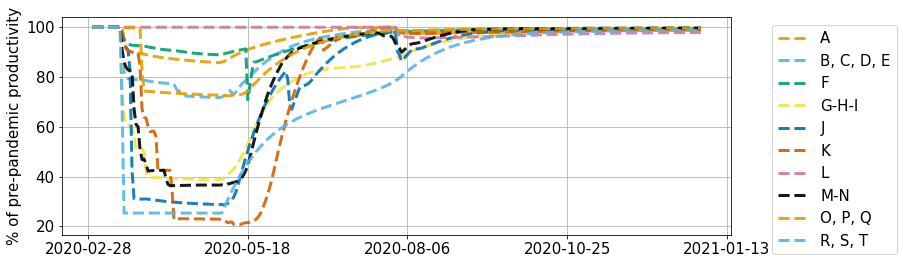

In [118]:
labels=pd.read_excel("../../data/interim/economical/conversion_matrices.xlsx", sheet_name = 'NACE 21 to NACE 10', header=[0], index_col=[0]).index.values

fig,ax=plt.subplots(figsize=(12,4))
for i in range(x_10.shape[0]):
    ax.plot(out['time'],x_10[i,:]/x_10[i,0]*100,ls='--',linewidth=3, alpha=0.9)

ax.xaxis.set_major_locator(plt.MaxNLocator(5))
ax.grid('on')
ax.set_ylabel('% of pre-pandemic productivity')
ax.legend(labels,bbox_to_anchor=(1.05, 1), loc='upper left')
fig.savefig('labor_breakdown_NACE10.jpg',dpi=400, bbox_inches='tight')

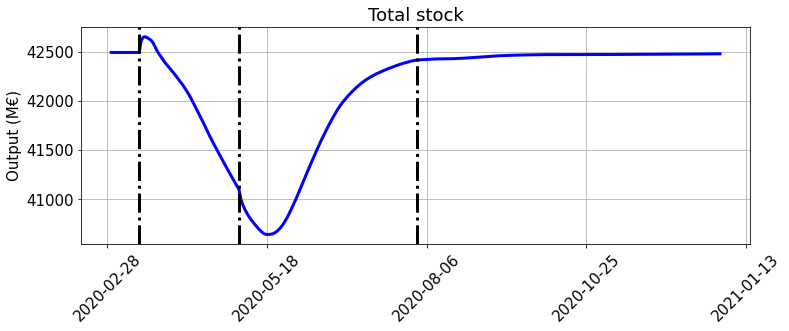

In [19]:
fig,ax=plt.subplots(figsize=(12,4))
ax.plot(out['time'],out['S'].sum(dim='A').sum(dim='A'),color='blue')
ax.axvline(t_start_lockdown,color='black',linestyle='-.')
ax.axvline(t_end_lockdown,color='black',linestyle='-.')
ax.axvline(t_end_pandemic,color='black',linestyle='-.')
ax.set_title('Total stock')
ax.xaxis.set_major_locator(plt.MaxNLocator(5))
for tick in ax.get_xticklabels():
    tick.set_rotation(45)
ax.set_ylabel('Output (M€)')
ax.grid('on')